<a href="https://colab.research.google.com/github/florestony54/skin-lesion/blob/main/skin_lesion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import PIL
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import pathlib
from tensorflow.python.client import device_lib

# Checking for GPU and device details

In [ ]:
devices = device_lib.list_local_devices()
if len(devices) > 1:
  gpu_details = devices[1].physical_device_desc.split(",")
  print("GPU detected: {}".format(gpu_details[1]))
else:
  print("No GPU detected.")


GPU detected:  name: Tesla P100-PCIE-16GB


# Loading Image data and Preprocessing

In [ ]:
!mkdir lesion_data

Unzipping raw image data from Drive to the lesion_data directory. Using flow_from_directory() from a mounted Google Drive directory is a huge bottleneck on the training process, so unzipping to a Colab directory here is a necessity.

In [ ]:
!unzip -uq "/content/drive/My Drive/lesion_data.zip" -d "/content/lesion_data/"

In [ ]:
data_dir = "/content/lesion_data/Takeout/Drive/data"

Here we can see each split of the image data (train/ validation/ test) contains 7 subdirectories, one for each classification.

In [ ]:
data_dir = pathlib.Path(data_dir)
train_dir =os.path.join(data_dir, "train")
val_dir =os.path.join(data_dir, "val")
test_dir=os.path.join(data_dir, "test")

train_count = os.listdir(train_dir)
val_count = os.listdir(val_dir)
test_count = os.listdir(test_dir )
print(len(train_count))
print(len(val_count))
print(len(test_count))

7
7
7


In [ ]:
class_names = os.listdir(train_dir)
class_names

['df', 'nv', 'bkl', 'mel', 'vasc', 'akiec', 'bcc']

Downscaling the images and setting the batch size.

In [ ]:
batch_size = 64
img_height = 450//3
img_width = 600//3
target_size = (img_height, img_width)

Here we augment the training images, to slightly alter the array representation.
 




In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    rotation_range = 20,
    zoom_range = 0.1,
    horizontal_flip = True,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
)

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    shuffle = True,
    seed = 930,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 6411 images belonging to 7 classes.


In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
val_data = val_datagen.flow_from_directory(
    val_dir,
    shuffle = True,
    seed =930,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1601 images belonging to 7 classes.


# Exploring the Training Image Data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


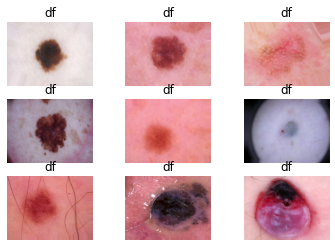

In [ ]:
tr_img = train_data.next()

for i in range(9):
  ax = plt.subplot(3,3, i + 1)
  image = tr_img[0][i]
  plt.imshow(image)
  plt.title(class_names[ class_names == tr_img[1][i]])
  plt.axis("off")

In [ ]:
from collections import Counter
class_count = Counter(train_data.classes)
class_count_list = []
[class_count_list.append(x) for x in class_count.values()]
class_count_list

[206, 328, 706, 73, 703, 4299, 96]

<BarContainer object of 7 artists>

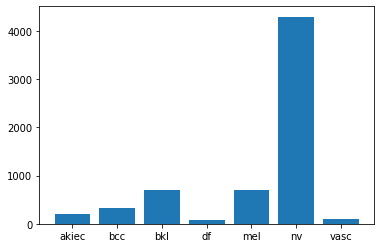

In [ ]:
plt.bar(train_data.class_indices.keys(), height=class_count_list)

# Class Weights
Here we will calculate the class weights for each class, based on their distribution in the training set. Since the dataset is imbalanced we want our model to be more sensitive to classes that are underrepresented, to try and avoid overfitting the majority class (nv in this case)

In [ ]:
class_weight = {}

for i in range(7):
  weight_name = "weight_for_" + str(i)
  weight_var = (1 / class_count_list[i])*(6411)/7.0 
  class_weight.update({i: weight_var})
  print('{}: {:.2f}'.format(weight_name, weight_var))

print(class_weight)

weight_for_0: 4.45
weight_for_1: 2.79
weight_for_2: 1.30
weight_for_3: 12.55
weight_for_4: 1.30
weight_for_5: 0.21
weight_for_6: 9.54
{0: 4.445908460471567, 1: 2.792247386759582, 2: 1.2972480777013355, 3: 12.545988258317024, 4: 1.3027839869945133, 5: 0.21303957731033796, 6: 9.540178571428571}


In [ ]:
def plot_model_acc(history):
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

# Model Architecture 1

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Conv2D(32, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(32,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(32,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax') 
])

# Run 1 - LR = 0.001, epochs = 30

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

Epoch 1/30
51/51 [==============================] - 169s 3s/step - loss: 2.8184 - accuracy: 0.3185 - val_loss: 4.3743 - val_accuracy: 0.0112
Epoch 2/30
51/51 [==============================] - 167s 3s/step - loss: 1.4907 - accuracy: 0.4877 - val_loss: 7.1529 - val_accuracy: 0.0162
Epoch 3/30
51/51 [==============================] - 167s 3s/step - loss: 1.2985 - accuracy: 0.5240 - val_loss: 6.8962 - val_accuracy: 0.0162
Epoch 4/30
51/51 [==============================] - 166s 3s/step - loss: 1.3678 - accuracy: 0.5209 - val_loss: 7.0732 - val_accuracy: 0.0468
Epoch 5/30
51/51 [==============================] - 166s 3s/step - loss: 1.3169 - accuracy: 0.5327 - val_loss: 6.5330 - val_accuracy: 0.0756
Epoch 6/30
51/51 [==============================] - 167s 3s/step - loss: 1.2406 - accuracy: 0.5357 - val_loss: 6.0832 - val_accuracy: 0.0493
Epoch 7/30
51/51 [==============================] - 167s 3s/step - loss: 1.1306 - accuracy: 0.5544 - val_loss: 5.2089 - val_accuracy: 0.0487
Epoch 8/30
51

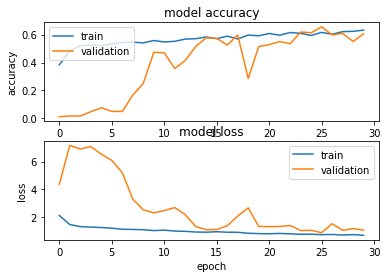

In [ ]:
model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs=30
)
plot_model_acc(model_history)

Saving Run 1 Model

In [ ]:
model_path = "/content/drive/MyDrive/models/Runs/run1"
model.save( model_path )

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run1/assets


Generating Test Dataset

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    shuffle = True,
    seed =930,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 2003 images belonging to 7 classes.


Evaluating Run-1 Model on test data

In [ ]:
model.evaluate(test_data)

16/16 [==============================] - 24s 2s/step - loss: 1.2141 - accuracy: 0.5866


[1.2140990495681763, 0.5866200923919678]

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_8 (Batch (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, None, None, 32)   

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_data)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())  

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.03      0.07      0.05        69
         bcc       0.07      0.14      0.09        91
         bkl       0.10      0.06      0.08       236
          df       0.01      0.03      0.02        29
         mel       0.12      0.18      0.14       228
          nv       0.67      0.49      0.56      1331
        vasc       0.01      0.05      0.02        19

    accuracy                           0.36      2003
   macro avg       0.14      0.15      0.14      2003
weighted avg       0.48      0.36      0.41      2003



# Run 2 - Learning Rate = 0.001, 50 Epochs

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Conv2D(32, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(32,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(32,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax') 
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.001 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

Epoch 1/50
51/51 [==============================] - 168s 3s/step - loss: 3.5555 - accuracy: 0.3102 - val_loss: 2.3837 - val_accuracy: 0.0131
Epoch 2/50
51/51 [==============================] - 166s 3s/step - loss: 1.5340 - accuracy: 0.4600 - val_loss: 4.0966 - val_accuracy: 0.0593
Epoch 3/50
51/51 [==============================] - 166s 3s/step - loss: 1.4007 - accuracy: 0.5059 - val_loss: 3.7215 - val_accuracy: 0.0612
Epoch 4/50
51/51 [==============================] - 166s 3s/step - loss: 1.3548 - accuracy: 0.5090 - val_loss: 5.4436 - val_accuracy: 0.0331
Epoch 5/50
51/51 [==============================] - 166s 3s/step - loss: 1.2551 - accuracy: 0.5450 - val_loss: 2.7886 - val_accuracy: 0.2299
Epoch 6/50
51/51 [==============================] - 167s 3s/step - loss: 1.1987 - accuracy: 0.5296 - val_loss: 3.4632 - val_accuracy: 0.1081
Epoch 7/50
51/51 [==============================] - 167s 3s/step - loss: 1.2344 - accuracy: 0.5110 - val_loss: 5.1091 - val_accuracy: 0.0568
Epoch 8/50
51

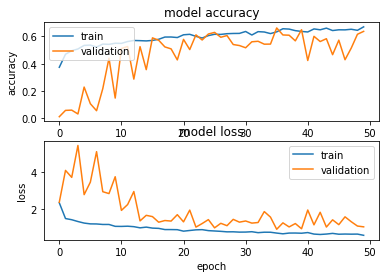

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run2/assets


In [ ]:
model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs=50
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run2"
model.save( model_path )

# Run 3 - Learning Rate = 0.001, 30 Epochs, Filters = 64

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax') 
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.001 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

Epoch 1/30
101/101 [==============================] - 189s 2s/step - loss: 3.9683 - accuracy: 0.3523 - val_loss: 5.5548 - val_accuracy: 0.0325
Epoch 2/30
101/101 [==============================] - 175s 2s/step - loss: 1.5382 - accuracy: 0.4642 - val_loss: 15.2177 - val_accuracy: 0.0325
Epoch 3/30
101/101 [==============================] - 178s 2s/step - loss: 1.4871 - accuracy: 0.4501 - val_loss: 6.6000 - val_accuracy: 0.0325
Epoch 4/30
101/101 [==============================] - 177s 2s/step - loss: 1.3530 - accuracy: 0.4797 - val_loss: 8.4833 - val_accuracy: 0.0706
Epoch 5/30
101/101 [==============================] - 177s 2s/step - loss: 1.3833 - accuracy: 0.4962 - val_loss: 2.6706 - val_accuracy: 0.1886
Epoch 6/30
101/101 [==============================] - 178s 2s/step - loss: 1.3539 - accuracy: 0.5019 - val_loss: 1.6395 - val_accuracy: 0.4416
Epoch 7/30
101/101 [==============================] - 178s 2s/step - loss: 1.4442 - accuracy: 0.4836 - val_loss: 1.4030 - val_accuracy: 0.496

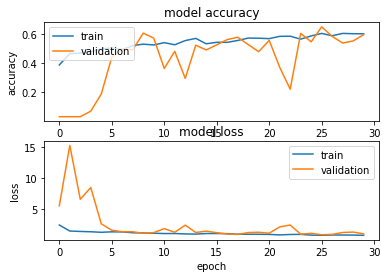

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run3/assets


In [ ]:
model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs=30
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run3"
model.save( model_path )

Epoch 1/50
101/101 [==============================] - 168s 2s/step - loss: 2.9627 - accuracy: 0.3677 - val_loss: 15.3872 - val_accuracy: 0.0169
Epoch 2/50
101/101 [==============================] - 156s 2s/step - loss: 1.4362 - accuracy: 0.5012 - val_loss: 12.5920 - val_accuracy: 0.0169
Epoch 3/50
101/101 [==============================] - 155s 2s/step - loss: 1.3232 - accuracy: 0.5154 - val_loss: 9.7439 - val_accuracy: 0.0981
Epoch 4/50
101/101 [==============================] - 151s 1s/step - loss: 1.3219 - accuracy: 0.5196 - val_loss: 8.5983 - val_accuracy: 0.0568
Epoch 5/50
101/101 [==============================] - 149s 1s/step - loss: 1.2707 - accuracy: 0.5056 - val_loss: 6.3181 - val_accuracy: 0.0606
Epoch 6/50
101/101 [==============================] - 149s 1s/step - loss: 1.1680 - accuracy: 0.5485 - val_loss: 3.3363 - val_accuracy: 0.2592
Epoch 7/50
101/101 [==============================] - 150s 1s/step - loss: 1.1030 - accuracy: 0.5623 - val_loss: 1.8767 - val_accuracy: 0.45

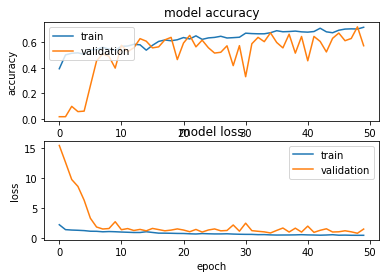

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run4/assets


In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax') 
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.0005 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs=50
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run4"
model.save( model_path )

In [ ]:
from sklearn.metrics import classification_report

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    shuffle = True,
    seed =930,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

predictions = model.predict(test_data)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())  

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 2003 images belonging to 7 classes.
              precision    recall  f1-score   support

       akiec       0.05      0.06      0.05        69
         bcc       0.09      0.08      0.08        91
         bkl       0.13      0.26      0.17       236
          df       0.02      0.14      0.03        29
         mel       0.12      0.18      0.14       228
          nv       0.69      0.42      0.52      1331
        vasc       0.00      0.00      0.00        19

    accuracy                           0.34      2003
   macro avg       0.16      0.16      0.14      2003
weighted avg       0.50      0.34      0.39      2003



In [ ]:
model.evaluate(test_data)

32/32 [==============================] - 18s 548ms/step - loss: 1.5827 - accuracy: 0.5517


[1.5827323198318481, 0.5516725182533264]

# Run 5 - LR = 0.001, 65 Epochs

Epoch 1/65
101/101 [==============================] - 154s 2s/step - loss: 4.0869 - accuracy: 0.3442 - val_loss: 10.5601 - val_accuracy: 0.0593
Epoch 2/65
101/101 [==============================] - 148s 1s/step - loss: 1.5667 - accuracy: 0.4114 - val_loss: 8.2558 - val_accuracy: 0.0593
Epoch 3/65
101/101 [==============================] - 147s 1s/step - loss: 1.3961 - accuracy: 0.4949 - val_loss: 6.1163 - val_accuracy: 0.1093
Epoch 4/65
101/101 [==============================] - 146s 1s/step - loss: 1.2471 - accuracy: 0.5210 - val_loss: 6.6534 - val_accuracy: 0.1012
Epoch 5/65
101/101 [==============================] - 147s 1s/step - loss: 1.1467 - accuracy: 0.5486 - val_loss: 2.7026 - val_accuracy: 0.3641
Epoch 6/65
101/101 [==============================] - 146s 1s/step - loss: 1.3053 - accuracy: 0.5260 - val_loss: 1.6705 - val_accuracy: 0.5621
Epoch 7/65
101/101 [==============================] - 151s 1s/step - loss: 1.1797 - accuracy: 0.5274 - val_loss: 1.4422 - val_accuracy: 0.653

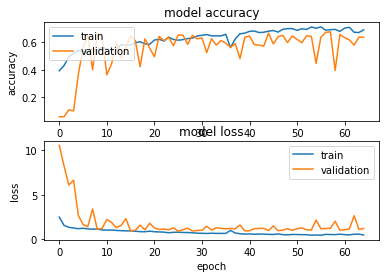

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run5/assets


In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax')
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.0005 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs= 65
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run5"
model.save( model_path )

# Run 6 - LR = 0.0001


Epoch 1/65
101/101 [==============================] - 151s 1s/step - loss: 2.6100 - accuracy: 0.3357 - val_loss: 4.5962 - val_accuracy: 0.0593
Epoch 2/65
101/101 [==============================] - 149s 1s/step - loss: 1.5819 - accuracy: 0.4690 - val_loss: 7.3554 - val_accuracy: 0.0593
Epoch 3/65
101/101 [==============================] - 152s 2s/step - loss: 1.3806 - accuracy: 0.4937 - val_loss: 9.4936 - val_accuracy: 0.0600
Epoch 4/65
101/101 [==============================] - 152s 2s/step - loss: 1.2623 - accuracy: 0.5150 - val_loss: 8.8386 - val_accuracy: 0.0593
Epoch 5/65
101/101 [==============================] - 150s 1s/step - loss: 1.2381 - accuracy: 0.5337 - val_loss: 7.6482 - val_accuracy: 0.0668
Epoch 6/65
101/101 [==============================] - 149s 1s/step - loss: 1.1936 - accuracy: 0.5421 - val_loss: 6.6249 - val_accuracy: 0.0675
Epoch 7/65
101/101 [==============================] - 147s 1s/step - loss: 1.0643 - accuracy: 0.5447 - val_loss: 6.1524 - val_accuracy: 0.0956

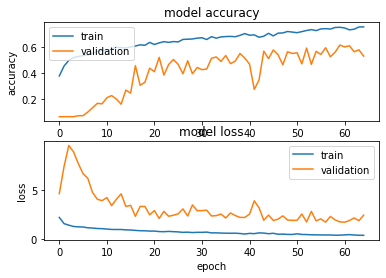

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run6/assets


In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.2),
  layers.Conv2D(64,3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax') 
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.0001 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs= 65
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run6"
model.save( model_path )

# Run 7 - Run 5 equivalent with L2 Regularization

Epoch 1/25
101/101 [==============================] - 161s 2s/step - loss: 4.5675 - accuracy: 0.3969 - val_loss: 6.7288 - val_accuracy: 0.0650
Epoch 2/25
101/101 [==============================] - 155s 2s/step - loss: 3.2472 - accuracy: 0.4938 - val_loss: 5.1054 - val_accuracy: 0.2630
Epoch 3/25
101/101 [==============================] - 155s 2s/step - loss: 3.0119 - accuracy: 0.4917 - val_loss: 6.8989 - val_accuracy: 0.1024
Epoch 4/25
101/101 [==============================] - 157s 2s/step - loss: 2.6885 - accuracy: 0.5146 - val_loss: 5.9084 - val_accuracy: 0.3404
Epoch 5/25
101/101 [==============================] - 156s 2s/step - loss: 2.6473 - accuracy: 0.5263 - val_loss: 4.6227 - val_accuracy: 0.2230
Epoch 6/25
101/101 [==============================] - 156s 2s/step - loss: 2.4296 - accuracy: 0.5566 - val_loss: 3.5148 - val_accuracy: 0.3879
Epoch 7/25
101/101 [==============================] - 155s 2s/step - loss: 2.2101 - accuracy: 0.5678 - val_loss: 2.6934 - val_accuracy: 0.5259

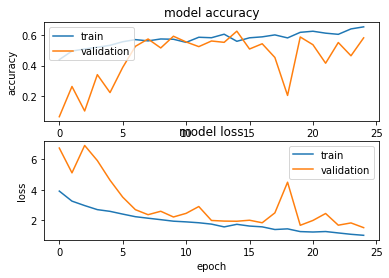

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run7/assets


In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu',kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64, 3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax')
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.0005 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs= 25
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run7"
model.save( model_path )

# Run 8 - Run 7 Equivalent but downscaled 3x instead of 2x


Epoch 1/25
101/101 [==============================] - 110s 1s/step - loss: 4.1316 - accuracy: 0.4095 - val_loss: 4.6055 - val_accuracy: 0.0081
Epoch 2/25
101/101 [==============================] - 101s 1s/step - loss: 3.0421 - accuracy: 0.4978 - val_loss: 5.7490 - val_accuracy: 0.0593
Epoch 3/25
101/101 [==============================] - 100s 994ms/step - loss: 2.8796 - accuracy: 0.5413 - val_loss: 4.6125 - val_accuracy: 0.0837
Epoch 4/25
101/101 [==============================] - 101s 998ms/step - loss: 2.4923 - accuracy: 0.5731 - val_loss: 3.3530 - val_accuracy: 0.5459
Epoch 5/25
101/101 [==============================] - 101s 1s/step - loss: 2.4355 - accuracy: 0.5772 - val_loss: 9.9155 - val_accuracy: 0.0618
Epoch 6/25
101/101 [==============================] - 101s 996ms/step - loss: 2.2359 - accuracy: 0.5884 - val_loss: 3.5554 - val_accuracy: 0.3660
Epoch 7/25
101/101 [==============================] - 101s 997ms/step - loss: 2.1567 - accuracy: 0.5715 - val_loss: 2.2970 - val_accu

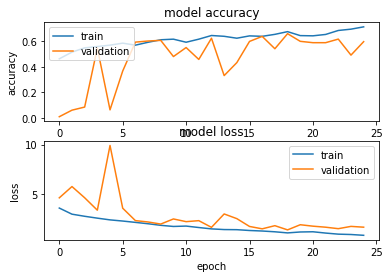

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run8/assets


In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu',kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64, 3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax')
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.0005 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs= 25
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run8"
model.save( model_path )

# Run 9 - 50 Epochs Downscaled 3x

In [ ]:
batch_size = 64
img_height = 450//3
img_width = 600//3
target_size = (img_height, img_width)

Epoch 1/50
101/101 [==============================] - 102s 1s/step - loss: 4.3026 - accuracy: 0.3977 - val_loss: 8.1835 - val_accuracy: 0.0169
Epoch 2/50
101/101 [==============================] - 100s 995ms/step - loss: 2.9784 - accuracy: 0.5231 - val_loss: 9.8230 - val_accuracy: 0.0237
Epoch 3/50
101/101 [==============================] - 101s 998ms/step - loss: 2.7048 - accuracy: 0.5438 - val_loss: 6.7124 - val_accuracy: 0.0743
Epoch 4/50
101/101 [==============================] - 100s 994ms/step - loss: 2.6028 - accuracy: 0.5565 - val_loss: 5.4964 - val_accuracy: 0.1505
Epoch 5/50
101/101 [==============================] - 100s 995ms/step - loss: 2.3864 - accuracy: 0.5596 - val_loss: 5.0186 - val_accuracy: 0.1755
Epoch 6/50
101/101 [==============================] - 101s 996ms/step - loss: 2.2179 - accuracy: 0.5992 - val_loss: 4.2234 - val_accuracy: 0.2611
Epoch 7/50
101/101 [==============================] - 100s 991ms/step - loss: 2.1290 - accuracy: 0.5956 - val_loss: 2.1291 - va

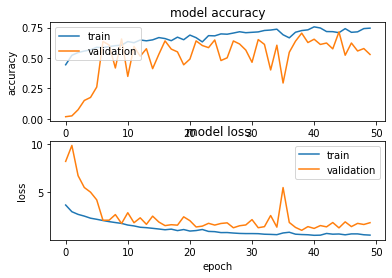

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run9/assets


In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu',kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64, 3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2', use_bias=True),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax')
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.0005 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs= 50
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run9"
model.save( model_path )

# Run 10

Epoch 1/50
101/101 [==============================] - 102s 1s/step - loss: 4.5412 - accuracy: 0.3842 - val_loss: 6.5018 - val_accuracy: 0.0675
Epoch 2/50
101/101 [==============================] - 100s 992ms/step - loss: 3.0519 - accuracy: 0.5283 - val_loss: 9.0444 - val_accuracy: 0.0600
Epoch 3/50
101/101 [==============================] - 100s 994ms/step - loss: 2.8526 - accuracy: 0.5328 - val_loss: 6.8654 - val_accuracy: 0.0394
Epoch 4/50
101/101 [==============================] - 101s 1s/step - loss: 2.6129 - accuracy: 0.5414 - val_loss: 6.7599 - val_accuracy: 0.0906
Epoch 5/50
101/101 [==============================] - 100s 995ms/step - loss: 2.4085 - accuracy: 0.5889 - val_loss: 3.8712 - val_accuracy: 0.2904
Epoch 6/50
101/101 [==============================] - 100s 993ms/step - loss: 2.2714 - accuracy: 0.6050 - val_loss: 4.7082 - val_accuracy: 0.1649
Epoch 7/50
101/101 [==============================] - 100s 994ms/step - loss: 2.1190 - accuracy: 0.5946 - val_loss: 3.0392 - val_a

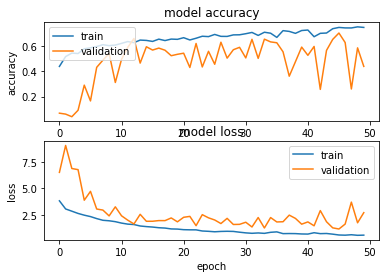

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Runs/run10/assets


In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu',kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64, 3, activation='relu', kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Conv2D(64,3, activation='relu', kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(7),
  layers.Activation('softmax')
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=  0.0005 ),
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'] 
)

model_history = model.fit(
    train_data,
    validation_data = val_data,
    class_weight = class_weight,
    epochs= 50
)
plot_model_acc(model_history)
model_path = "/content/drive/MyDrive/models/Runs/run10"
model.save( model_path )